In [1]:
import numpy as np

def sigmoid(input):
 return 1.0 / (1 + np.exp(-input))

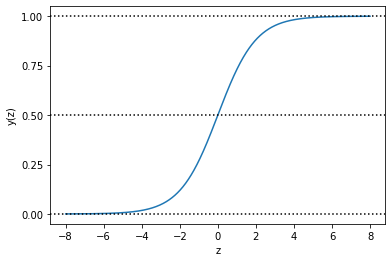

In [2]:
z = np.linspace(-8, 8, 1000)
y = sigmoid(z)

import matplotlib.pyplot as plt
plt.plot(z, y)
plt.axhline(y=0, ls='dotted', color='k')
plt.axhline(y=0.5, ls='dotted', color='k')
plt.axhline(y=1, ls='dotted', color='k')
plt.yticks([0.0, 0.25, 0.5, 0.75, 1.0])
plt.xlabel('z')
plt.ylabel('y(z)')
plt.show()

In [4]:
from sklearn.feature_extraction import DictVectorizer
import pandas as pd

data = pd.read_csv('ctr_data_20000.csv')
data = data.drop(['id', 'hour', 'device_id', 'device_ip'], axis = 1)

data_X = data.loc[ :, data.columns != 'click'].astype('str')
data_y = data.loc[ :, data.columns == 'click'].astype('int').values.ravel()

train_X, test_X = data_X[0:15000], data_X[15000:]
train_y, test_y = data_y[0:15000], data_y[15000:]

dict_one_hot_encoder = DictVectorizer(sparse=False)
onehot_train_X = dict_one_hot_encoder.fit_transform(train_X.to_dict('records'))
onehot_test_X = dict_one_hot_encoder.transform(test_X.to_dict('records'))

print(train_X.shape)
print(onehot_train_X.shape)

(15000, 19)
(15000, 3244)


In [5]:
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression


logistic_regression =  LogisticRegression(fit_intercept=True, max_iter = 10000)
logistic_regression.fit(onehot_train_X, train_y)

pos_prob = logistic_regression.predict_proba(onehot_test_X)[:,1]
print('The ROC AUC testing set is :{0:.3f}'.format(roc_auc_score(test_y, pos_prob)))

The ROC AUC testing set is :0.710


In [6]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

parameters = {'eta0': [0.1, 0.01, 0.001]}

sdg_lr = SGDClassifier(loss='log', fit_intercept=True)

grid_search = GridSearchCV(sdg_lr, parameters, n_jobs=-1, cv=3, scoring='roc_auc')

grid_search.fit(onehot_train_X, train_y)

sgd_lr_best = grid_search.best_estimator_
pos_prob = sgd_lr_best.predict_proba(onehot_test_X)[:,1]
print('The ROC AUC testing set is :{0:.3f}'.format(roc_auc_score(test_y, pos_prob)))

The ROC AUC testing set is :0.708


In [7]:
from sklearn.linear_model import SGDClassifier

parameters = {'eta0': [0.1, 0.01, 0.001]}

sdg_lr = SGDClassifier(loss='log', fit_intercept=True, penalty = 'l2')

grid_search = GridSearchCV(sdg_lr, parameters, n_jobs=-1, cv=3, scoring='roc_auc')

grid_search.fit(onehot_train_X, train_y)

sgd_lr_best = grid_search.best_estimator_
pos_prob = sgd_lr_best.predict_proba(onehot_test_X)[:,1]
print('The ROC AUC testing set is :{0:.3f}'.format(roc_auc_score(test_y, pos_prob)))

The ROC AUC testing set is :0.710


In [8]:
import nltk
nltk.download('names')
nltk.download('wordnet')

[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Unzipping corpora/names.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [9]:
from nltk.corpus import names
from nltk.stem import WordNetLemmatizer

all_names = set(names.words())
lemmatizer = WordNetLemmatizer()

def clean_text(docs):
  cleaned_docs = []
  for doc in docs:
    lemmatized_list = [ lemmatizer.lemmatize (word.lower())
                            for word in doc.split()
                            if word.isalpha() and word not in all_names] 
    cleaned_docs.append(' '.join(lemmatized_list))
  return cleaned_docs 

In [10]:
from sklearn.datasets import fetch_20newsgroups

data_train = fetch_20newsgroups(subset='train', categories=None, random_state=42)
data_test = fetch_20newsgroups(subset='test', categories=None, random_state=42)

In [11]:
cleaned_train = clean_text(data_train.data)
label_train = data_train.target

cleaned_test = clean_text(data_test.data)
label_test = data_test.target

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, stop_words='english', max_features=40000)
term_docs_train = tfidf_vectorizer.fit_transform(cleaned_train)
term_docs_test = tfidf_vectorizer.transform(cleaned_test)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier

parameters = {'penalty': ['l2', None], 
              'alpha': [1e-07, 1e-06, 1e-05, 1e-04],
              'eta0': [0.01, 0.1, 1, 10]}

sgd_lr = SGDClassifier(loss='log', learning_rate='constant', eta0=0.01, fit_intercept=True)

grid_search = GridSearchCV(sgd_lr, parameters, n_jobs=-1, cv=3)
grid_search.fit(term_docs_train, label_train)
print(grid_search.best_params_)

{'alpha': 1e-06, 'eta0': 10, 'penalty': None}


In [ ]:
sgd_lr_best = grid_search.best_estimator_
accuracy = sgd_lr_best.score(term_docs_test, label_test)
print('The accuracy on testing set is: {0:.1f}%'.format(accuracy*100))

The accuracy on testing set is: 79.6%
